# Kernel based qiskit angle

## Load and preprocess our data

In [1]:
# get pandas running
import pandas as pd
import numpy as np

In [2]:
#read in dataset
df2 = pd.read_excel("XOR Fuzzy.xlsx")
df2.head()

print(df2.shape)
print(df2.columns)
description = df2.describe()

(1000, 4)
Index(['Unnamed: 0', 'X1', 'X2', 'Target'], dtype='object')


In [3]:
# drop not needed columns
df2.drop(columns=df2.columns[0], axis=1, inplace=True)
print(df2.columns)
description = df2.describe()
print(description)

# split in train and test data
df_train, df_test = np.split(df2, [int(len(df2)*0.7)])

# see if train and test data are quite the same
print(df_train.describe())
print(df_test.describe())

Index(['X1', 'X2', 'Target'], dtype='object')
                X1           X2      Target
count  1000.000000  1000.000000  1000.00000
mean      0.488224     0.493889     0.50000
std       0.290966     0.296587     0.50025
min       0.000067     0.000428     0.00000
25%       0.230494     0.229903     0.00000
50%       0.495980     0.499074     0.50000
75%       0.745465     0.752604     1.00000
max       0.997674     0.998858     1.00000
               X1          X2      Target
count  700.000000  700.000000  700.000000
mean     0.479748    0.507664    0.502857
std      0.294930    0.296724    0.500349
min      0.000067    0.000428    0.000000
25%      0.210721    0.239447    0.000000
50%      0.481823    0.521934    1.000000
75%      0.740105    0.773955    1.000000
max      0.997674    0.998858    1.000000
               X1          X2      Target
count  300.000000  300.000000  300.000000
mean     0.508001    0.461747    0.493333
std      0.280987    0.294257    0.500791
min      0.0

In [4]:
# split in input X and output y
def get_features_and_targets(df):
    X = df.drop(["Target"], axis=1).values
    y = np.stack(df["Target"])
    return X, y

X_train, y_train = get_features_and_targets(df_train)
X_test, y_test = get_features_and_targets(df_test)

y_train = y_train * 2 - np.ones(len(y_train))  # shift label from {0, 1} to {-1, 1}
y_test = y_test * 2 - np.ones(len(y_test))  # shift label from {0, 1} to {-1, 1}

print(X_train)
print(y_train)

[[0.59140793 0.61561936]
 [0.1318304  0.34636674]
 [0.17758343 0.8405715 ]
 ...
 [0.99342062 0.24940961]
 [0.69330392 0.30243006]
 [0.00534434 0.93836599]]
[-1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.
 -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1.
 -1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.
  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. 

In [5]:
for i in range(10):
    print("X = {}, Y = {: d}".format(X_train[i], int(y_train[i])))

print("...")

X = [0.59140793 0.61561936], Y = -1
X = [0.1318304  0.34636674], Y = -1
X = [0.17758343 0.8405715 ], Y =  1
X = [0.52243622 0.34914641], Y =  1
X = [0.78618825 0.11890013], Y =  1
X = [0.96705057 0.87746943], Y = -1
X = [0.55442653 0.21768447], Y =  1
X = [0.16945119 0.82208864], Y =  1
X = [0.18198346 0.2113241 ], Y = -1
X = [0.80660522 0.61645197], Y = -1
...


## Now introduce our kernel

In [6]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

adhoc_dimension = 2

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

adhoc_svc = QSVC(quantum_kernel=adhoc_kernel)
adhoc_svc.fit(X_train, y_train)
qsvc_score = adhoc_svc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.97


Score of 0.97. This seems to be quite good!

In [7]:
predictions = adhoc_svc.predict(X_test)

## Now some results

In [8]:
for i in range(10):
    print("X = {}, Y-test = {: d}, Y-predicted = {: d}".format(X_test[i], int(y_test[i]), int(predictions[i])))

print("...")

X = [0.17513025 0.30930543], Y-test = -1, Y-predicted = -1
X = [0.26482202 0.47322026], Y-test = -1, Y-predicted = -1
X = [0.45537221 0.2772    ], Y-test = -1, Y-predicted = -1
X = [0.21787986 0.78921691], Y-test =  1, Y-predicted =  1
X = [0.63338171 0.13406739], Y-test =  1, Y-predicted =  1
X = [0.86626834 0.24023816], Y-test =  1, Y-predicted =  1
X = [0.33529998 0.86839197], Y-test =  1, Y-predicted =  1
X = [0.7809938 0.6456125], Y-test = -1, Y-predicted = -1
X = [0.08044739 0.68962111], Y-test =  1, Y-predicted =  1
X = [0.03490885 0.64884414], Y-test =  1, Y-predicted =  1
...


In [9]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print('F1 Score: %.3f' % f1_score(y_test, predictions))
print('Accuracy: %.3f' % accuracy_score(y_test, predictions))
print('Recall: %.3f' % recall_score(y_test, predictions))
print('Precision: %.3f' % precision_score(y_test, predictions))


F1 Score: 0.962
Accuracy: 0.963
Recall: 0.932
Precision: 0.993


## Confusion matrix

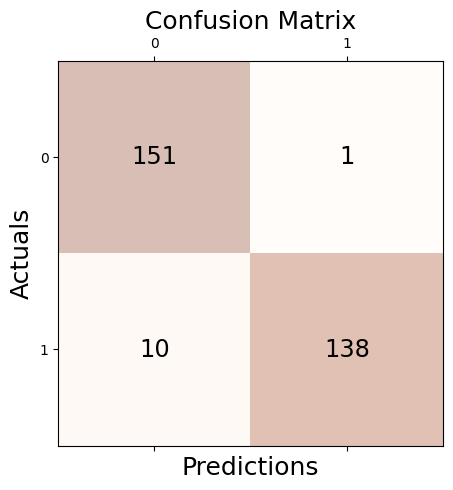

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()